In [1]:
# Preliminary data notebook for
# NIH: Imaging Guided Intervention Surgery Study Section

# Exploratory aim: evaluate presurgical scans between STN and GPi targets
#   Given retrospective GPi acquisitions?
#   Search for radiomic differentiators for STN versus GPi selection in presurgical scans

In [2]:
# Import libraries
from time import time
from joblib import Memory
from scipy import sparse
from scipy import linalg
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nibabel as nib
import tempfile
from sklearn.datasets import make_regression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import FeatureAgglomeration
from sklearn.cluster import ward_tree
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.feature_selection import SelectFromModel
import SimpleITK as sitk
import six
from radiomics import featureextractor 
from radiomics import imageoperations
import numpy as np
from numpy import linalg
import os
import pywt
from util import IndexTracker

%matplotlib widget

In [3]:
# Set window level
level = 0
window = 500
m1=level-window/2
m2=level+window/2

# Load data
# fig, ax = plt.subplots(2,5)
segs = []
qsms = []
voxel_sizes = []
trackers = []
directory = 'F:\dbs\outcome_predictor\snrn_cases'
case_list = []
for filename in os.listdir(directory):
    f = os.path.join(directory,filename)
    print(f)
    # Training cases
    if '47' not in filename:
        try:
            seg = nib.load(f+'/seg.nii')
        except:
            seg = nib.load(f+'/seg.nii.gz')
            
        voxel_size = seg.header['pixdim'][0:3]
        voxel_sizes.append(voxel_size)
        segs.append(seg.get_fdata())

        try:
            qsm = nib.load(f+'/qsm.nii')
        except:
            qsm = nib.load(f+'/qsm.nii.gz')
        qsms.append(qsm.get_fdata())
    # Test case
    else:
        try:
            seg_t = nib.load(f+'/seg.nii')
        except:
            seg_t = nib.load(f+'/seg.nii.gz')
        voxel_size_t = seg_t.header['pixdim'][0:3]
        try:
            qsm_t = nib.load(f+'/qsm.nii')
        except:
            qsm_t = nib.load(f+'/qsm.nii.gz')
    case_list.append(filename)
    n_cases = len(segs)
# qsm_plots = qsms
# seg_plots = segs
# qsm_plots.append(qsm_t.get_fdata())
# seg_plots.append(seg_t.get_fdata())
# count = 1
# r1_col_idx = 0
# r2_col_idx = 0
# for cases in range(n_cases-1):
#     # Set window/level
#     seg_tmp = seg_plots[count-1]
#     seg_tmp[seg_tmp>0] = 1
#     qsm_tmp = qsm_plots[count-1]
#     qsm_tmp[qsm_tmp<m1] = m1
#     qsm_tmp[qsm_tmp>m2] = m2
#     if np.mod(n_cases-1,count) == 0 or np.mod(n_cases-1,count)>3:
#         trackers.append(IndexTracker(ax[0][r1_col_idx],seg_tmp))
#         fig.canvas.mpl_connect('scroll_event', trackers[count-1].onscroll)   
#         ax[0][r1_col_idx].set_title(case_list[count-1])
#         r1_col_idx = r1_col_idx+1
#     else:
#         trackers.append(IndexTracker(ax[1][r2_col_idx],seg_tmp))
#         fig.canvas.mpl_connect('scroll_event', trackers[count-1].onscroll)   
#         ax[1][r2_col_idx].set_title(case_list[count-1])
#         r2_col_idx = r2_col_idx+1
#     count = count+1
   

F:\dbs\outcome_predictor\snrn_cases\044
F:\dbs\outcome_predictor\snrn_cases\046
F:\dbs\outcome_predictor\snrn_cases\040
F:\dbs\outcome_predictor\snrn_cases\029
F:\dbs\outcome_predictor\snrn_cases\032
F:\dbs\outcome_predictor\snrn_cases\039
F:\dbs\outcome_predictor\snrn_cases\012
F:\dbs\outcome_predictor\snrn_cases\007
F:\dbs\outcome_predictor\snrn_cases\001
F:\dbs\outcome_predictor\snrn_cases\047
F:\dbs\outcome_predictor\snrn_cases\034


In [4]:
# Generate feature structure Phi from all ROIs and all cases
extractor = featureextractor.RadiomicsFeatureExtractor()
extractor.enableAllFeatures()
extractor.enableAllImageTypes()
Phi = []
seg_t_sitk = sitk.GetImageFromArray(seg_t.get_fdata())
seg_t_sitk.SetSpacing(voxel_size_t.tolist())
qsm_t_sitk = sitk.GetImageFromArray(qsm_t.get_fdata())
qsm_t_sitk.SetSpacing(voxel_size_t.tolist())
# Create separate feature vector for test case
for j in range(1,int(np.max(segs[0]))+1):
    featureVector_t = extractor.execute(qsm_t_sitk,seg_t_sitk,label=j)

# Training cases
for i in range(n_cases):
    seg_sitk = sitk.GetImageFromArray(segs[i])
    seg_sitk.SetSpacing(voxel_sizes[i].tolist())
    qsm_sitk = sitk.GetImageFromArray(qsms[i])
    qsm_sitk.SetSpacing(voxel_sizes[i].tolist())
    for j in range(1,int(np.max(segs[i]))+1):
        featureVector = extractor.execute(qsm_sitk,seg_sitk,label=j)
        Phi.append(featureVector)


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Calculating Local Binary Pattern in 2D, but extracting features in 3D. Use with caution!
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculate

In [5]:
# Extract numeric feature values
n_ROIs = int(np.max(segs[i]))
x_row = []
loop_count = 0
for i in range(Phi.__len__()):
        featureVector = Phi[i]
        loop_count = loop_count+1
        for key, value in six.iteritems(featureVector):
            if 'diagnostic' in key:
                next
            else:
                x_row.append(value)
X0 = np.array(x_row)

# Test case
x_row_t = []
for j in range(int(np.max(segs[0]))):
        featureVector = featureVector_t
        loop_count = loop_count+1
        for key, value in six.iteritems(featureVector):
            if 'diagnostic' in key:
                next
            else:
                x_row_t.append(value)
X0_t = np.array(x_row_t)

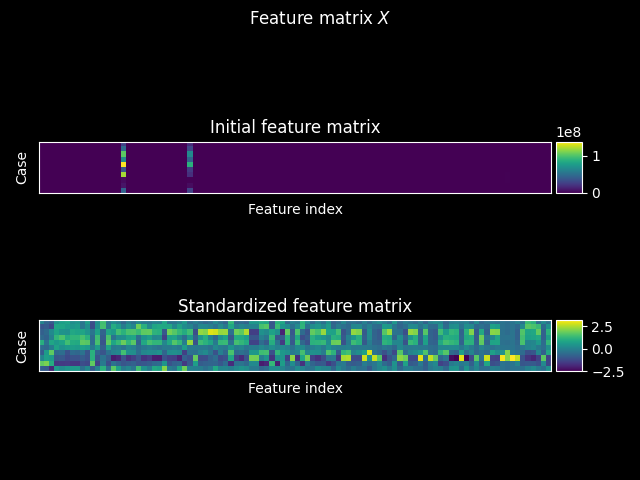

In [6]:
# Visualize feature matrix X
X = X0.reshape((n_cases,int(len(X0)/n_cases)))
fig,ax = plt.subplots(2,1)
plt.style.use('dark_background')
im0 = ax[0].imshow(X[:,0:100])
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title('Initial feature matrix')
ax[0].set_xlabel('Feature index')
ax[0].set_ylabel('Case')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im0, cax=cax, orientation='vertical')
# Normalize testing and training cases together
#   Otherwise the scale during clf.predict() is wrong
#   Set with_mean=False to preserve data sparsity
#   And with_std=False 
#   However, need a significant number of samples to do this
scaler = StandardScaler()
X_all = np.vstack((X,X0_t))
X_all_t = scaler.fit_transform(X_all)
X_t = X_all_t[X.shape[0]:,:]
X = X_all_t[:X.shape[0]]
im1 = ax[1].imshow(X[:,0:100])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xlabel('Feature index')
ax[1].set_ylabel('Case')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')
ax[1].set_title('Standardized feature matrix')
plt.suptitle('Feature matrix $X$');
plt.tight_layout()


In [7]:
# UPDRS targets
#   Must be ordered according to list-generating loop
#   Larger data arrays will need a text file in each directory
#   So targets and inputs can be read simultaneously

u = np.array([[3,10,24,2],
[1,3,18,2],
[2,10,26,8],
[3,3,25,0],
[0,0,13,0],
[0,10,33,4],
[1,4,11,1],
[0,7,25,1],
[0,1,24,1],
[3,8,32,4]])



In [8]:
# Cross-validation for model selection
cv = KFold(X.shape[0])
cachedir = tempfile.mkdtemp()
mem = Memory(location=cachedir, verbose=1)

# Dimensionality reduction
ward = FeatureAgglomeration(n_clusters=1, linkage='ward',memory=mem)
# Feature selection
lasso = Lasso(alpha=0,fit_intercept=False,max_iter=100000,tol=0.001)
# Initialize classifier pipeline
clf_in = Pipeline([('ward',ward),('Lasso',SelectFromModel(estimator=lasso,threshold='mean')),('SVM',OneVsRestClassifier(lasso))])
# Select the optimal number of clusters with grid search
alphas = ((1e-9,1e-6,1e-3,10e0,10e1,10e2))
N_clusters = [100,1000]
clf = GridSearchCV(clf_in, {'ward__n_clusters': N_clusters,'Lasso__estimator__alpha' : alphas, 'SVM__estimator__alpha' : alphas}, n_jobs=1, cv=cv, scoring='accuracy')
ut = []
for k in range(u.shape[1]):
    clf.fit(X,u[:,k])
    # make predictions
    ut.append(clf.best_estimator_.predict(X_t))

________________________________________________________________________________
[Memory] Calling sklearn.cluster._agglomerative.ward_tree...
ward_tree(array([[-1.00464 , ..., -0.838116],
       ...,
       [ 0.775431, ..., -0.876606]]), connectivity=None, n_clusters=None, return_distance=False)
________________________________________________________ward_tree - 0.9s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.cluster._agglomerative.ward_tree...
ward_tree(array([[ 0.002322, ..., -0.838116],
       ...,
       [-1.221826, ..., -0.876606]]), connectivity=None, n_clusters=None, return_distance=False)
________________________________________________________ward_tree - 0.8s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.cluster._agglomerative.ward_tree...
ward_tree(array([[ 0.002322, ..., -0.838116],
       ...,
       [-1.221826, ..., -0.876606]]), connec

5
(5, 46)


c:\Users\agr78\Anaconda3\envs\pdradenv\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


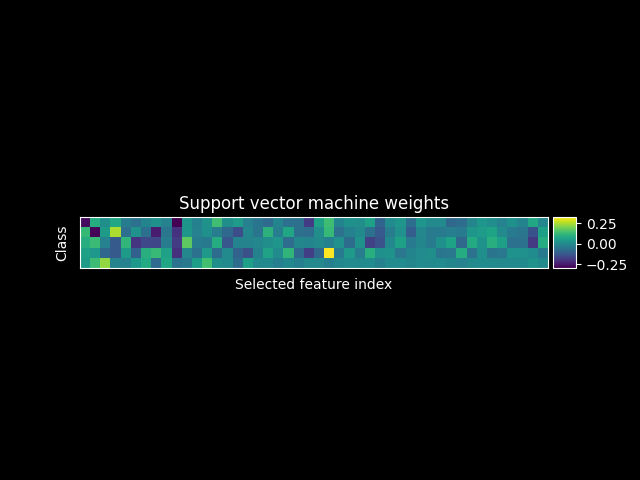

In [9]:
# # Set best parameters from cross-validation
# # Ward-Lasso w* of length reduced number of features in Xw

# # Lasso w* of length of original number of features in X
#coef_ = clf.best_estimator_.steps[0][1].inverse_transform(coef_lasso)

X_SVM = clf.best_estimator_.steps[2][1].coef_;
fig,ax = plt.subplots(1,1)
im_svm = plt.imshow(X_SVM)
plt.xticks([])
plt.yticks([])
plt.xlabel('Selected feature index')
plt.ylabel('Class')
plt.title('Support vector machine weights');
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im_svm,cax=cax,orientation='vertical')
print(clf.best_estimator_.steps[2][1].n_classes_)
print(X_SVM.shape)

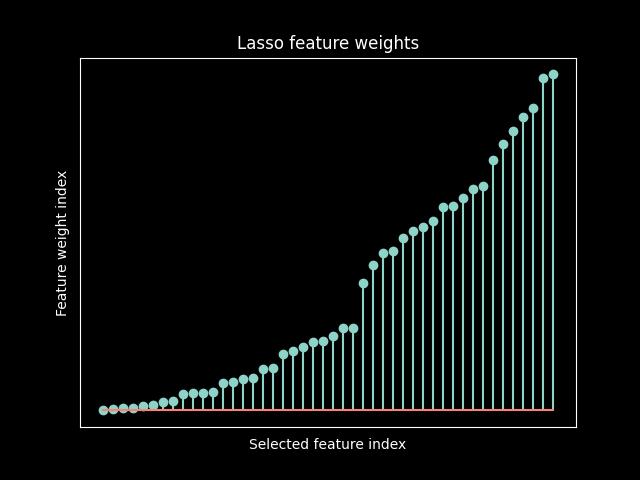

In [10]:
X_Lasso = np.nonzero(clf.best_estimator_.steps[1][1].inverse_transform(X_SVM))
fig,ax = plt.subplots(1,1)
plt.stem(X_Lasso[1][0:X_SVM.shape[1]])
plt.xticks([])
plt.yticks([])
plt.xlabel('Selected feature index')
plt.ylabel('Feature weight index')
plt.title('Lasso feature weights');

In [11]:
clf.best_estimator_.steps[1][1].inverse_transform(X_SVM).shape

(5, 1000)

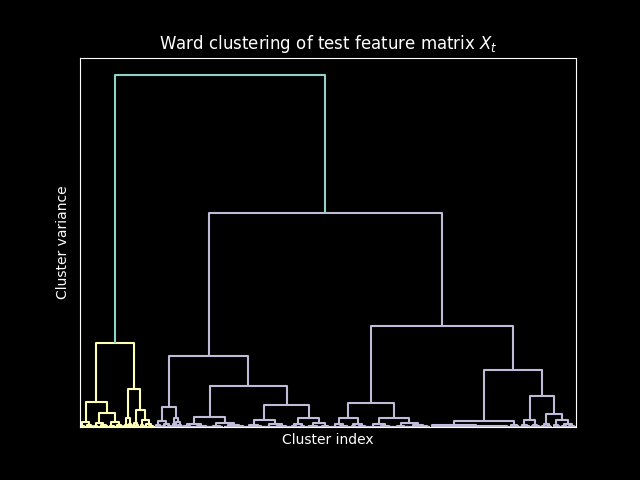

In [12]:
ward = FeatureAgglomeration(clf.best_estimator_.steps[0][1].n_clusters, linkage='ward',memory=mem)
Xw = linkage(X_t.T,'ward')
fig,ax = plt.subplots(1,1)
dendrogram(Xw)
plt.xticks([])
plt.yticks([])
plt.xlabel('Cluster index')
plt.ylabel('Cluster variance')
plt.title('Ward clustering of test feature matrix $X_t$')
plt.show()

In [13]:
ut0 = np.array((2,13,30,6))
ut = np.array(ut).T
u0 = np.mean(u,axis=0)

In [14]:
X_SVM.shape

(5, 46)

In [15]:
print('MSE for the constructed estimator output '+str(ut)+ ' is '+ str(np.mean((ut0-ut)**2)))
print('MSE for the sample mean '+str(np.round(u0))+ ' is '+ str(np.mean((ut0-u0)**2)))

MSE for the constructed estimator output [[ 3 10 26  8]] is 7.5
MSE for the sample mean [ 1.  6. 23.  2.] is 29.137499999999996


In [16]:
clf.best_estimator_.get_params()

{'memory': None,
 'steps': [('ward',
   FeatureAgglomeration(memory=Memory(location=C:\Users\agr78\AppData\Local\Temp\tmpj_imk92g\joblib),
                        n_clusters=1000)),
  ('Lasso',
   SelectFromModel(estimator=Lasso(alpha=0.001, fit_intercept=False,
                                   max_iter=100000, tol=0.001),
                   threshold='mean')),
  ('SVM',
   OneVsRestClassifier(estimator=Lasso(alpha=1e-09, fit_intercept=False,
                                       max_iter=100000, tol=0.001)))],
 'verbose': False,
 'ward': FeatureAgglomeration(memory=Memory(location=C:\Users\agr78\AppData\Local\Temp\tmpj_imk92g\joblib),
                      n_clusters=1000),
 'Lasso': SelectFromModel(estimator=Lasso(alpha=0.001, fit_intercept=False,
                                 max_iter=100000, tol=0.001),
                 threshold='mean'),
 'SVM': OneVsRestClassifier(estimator=Lasso(alpha=1e-09, fit_intercept=False,
                                     max_iter=100000, tol=0.0

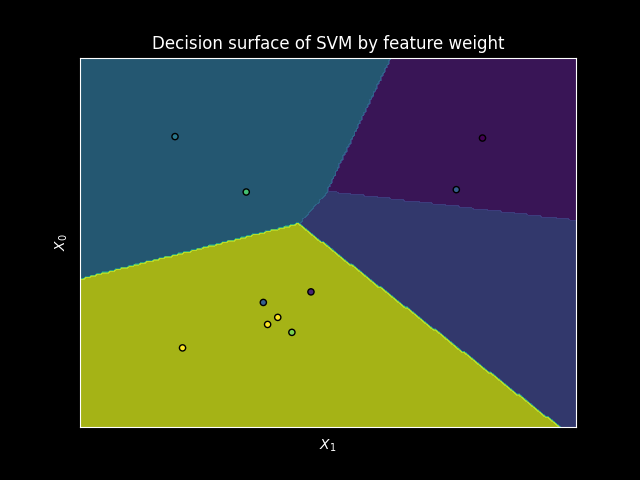

In [17]:
from skmultilearn.problem_transform.br import BinaryRelevance
from sklearn.svm import SVC

Xs = Xw.ravel()
up = u[:,1]
X0 = X[:,np.where(np.sort(Xs)[-1]==Xw)[0]]
X1 = X[:,np.where(np.sort(Xs)[-2]==Xw)[0]]



def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clfp.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

fig, ax = plt.subplots()
# title for the plots
title = ('Decision surface of SVM by feature weight')
# Set-up grid for plotting.
xx, yy = make_meshgrid(X0, X1)
clfp = OneVsRestClassifier(Lasso(alpha=clf.best_estimator_.steps[1][1].estimator.alpha)).fit(np.hstack((X0,X1)),u[:,1])
plot_contours(ax, clfp, xx, yy, cmap=plt.cm.viridis, alpha=0.8)
ax.scatter(X0, X1, c=u[:,1], cmap=plt.cm.viridis, s=20, edgecolors='k')
ax.set_ylabel('$X_0$')
ax.set_xlabel('$X_1$')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
plt.show()